# 05. Xác thực phân cụm & Đánh giá độ ổn định

Xác thực kết quả phân cụm và đảm bảo độ ổn định trên cả ba thuật toán.

Chúng tôi đánh giá:
1. **Kiểm tra độ ổn định** - Tính nhất quán qua nhiều lần chạy
2. **Phân tích độ nhạy** - Tác động của các tham số và đặc trưng
3. **Tác động của ngoại lai** - Độ ổn định khi có/không có ngoại lai
4. **Xác thực nghiệp vụ** - Sự phù hợp với kiến thức chuyên ngành
5. **So sánh thuật toán** - Thuật toán nào hoạt động tốt nhất

## 1. Thiết lập & Tải kết quả

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Load data
X = pd.read_csv('../data/transformed/customer_đặc trưng_transformed.csv')

# Clean data
if 'CustomerID' in X.columns:
    X = X.drop('CustomerID', axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()

# Load clustering results
cụm = pd.read_csv('../results/cluster_assignments.csv')

print(f'Dữ liệu đã tải: {len(X)} khách hàng, {len(X.columns)} đặc trưng')
print(f'\nKết quả phân cụm có sẵn:')
print(f'  K-Means: {cụm["KMeans_Cluster"].nunique()} cụm')
print(f'  DBSCAN: {cụm["DBSCAN_Cluster"].nunique()} nhóm (bao gồm nhiễu)')
print(f'  Hierarchical: {cụm["Hierarchical_Cluster"].nunique()} cụm')

from sklearn.tree import DecisionTreeClassifier, plot_tree
try:
    import shap
except ImportError:
    import subprocess
    import sys
    print('Installing shap...')
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap


FileNotFoundError: [Errno 2] No such file or directory: '../data/transformed/customer_đặc trưng_transformed.csv'

## 2. Kiểm tra độ ổn định

In [ ]:
# Run each algorithm multiple times to test stability
n_runs = 10
optimal_k = cụm['KMeans_Cluster'].nunique()

print(f'Đang chạy thuật toán {n_runs} lần để kiểm tra độ ổn định...\n')

# K-Means stability
print('K-Means Kiểm tra độ ổn định')
print('='*50)
kmeans_scores = []
for run in range(n_runs):
    kmeans = KMeans(n_cụm=optimal_k, random_state=run, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    kmeans_scores.append(sil)
    print(f'  Run {run+1}: Silhouette={sil:.4f}')

print(f'Trung bình: {np.mean(kmeans_scores):.4f} +/- {np.std(kmeans_scores):.4f}')
print(f'Độ ổn định: {"CAO" if np.std(kmeans_scores)/np.mean(kmeans_scores) < 0.05 else "TRUNG BÌNH" if np.std(kmeans_scores)/np.mean(kmeans_scores) < 0.10 else "THẤP"}')

# Hierarchical stability
print(f'\nHierarchical Clustering Kiểm tra độ ổn định')
print('='*50)
hier_scores = []
for run in range(n_runs):
    model = AgglomerativeClustering(n_cụm=optimal_k, linkage='ward')
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    hier_scores.append(sil)
    print(f'  Run {run+1}: Silhouette={sil:.4f}')

print(f'Trung bình: {np.mean(hier_scores):.4f} +/- {np.std(hier_scores):.4f}')
print(f'Độ ổn định: {"CAO" if np.std(hier_scores)/np.mean(hier_scores) < 0.05 else "TRUNG BÌNH" if np.std(hier_scores)/np.mean(hier_scores) < 0.10 else "THẤP"}')

Running algorithms 10 times to test stability...

K-Means Stability Testing
  Run 1: Silhouette=0.2547
  Run 2: Silhouette=0.2549
  Run 3: Silhouette=0.2549
  Run 4: Silhouette=0.2541
  Run 5: Silhouette=0.2549
  Run 6: Silhouette=0.2549
  Run 7: Silhouette=0.2541
  Run 8: Silhouette=0.2549
  Run 9: Silhouette=0.2541
  Run 10: Silhouette=0.2549
Mean: 0.2546 +/- 0.0004
Stability: HIGH

Hierarchical Clustering Stability Testing
  Run 1: Silhouette=0.1803
  Run 2: Silhouette=0.1803
  Run 3: Silhouette=0.1803
  Run 4: Silhouette=0.1803
  Run 5: Silhouette=0.1803
  Run 6: Silhouette=0.1803
  Run 7: Silhouette=0.1803
  Run 8: Silhouette=0.1803
  Run 9: Silhouette=0.1803
  Run 10: Silhouette=0.1803
Mean: 0.1803 +/- 0.0000
Stability: HIGH


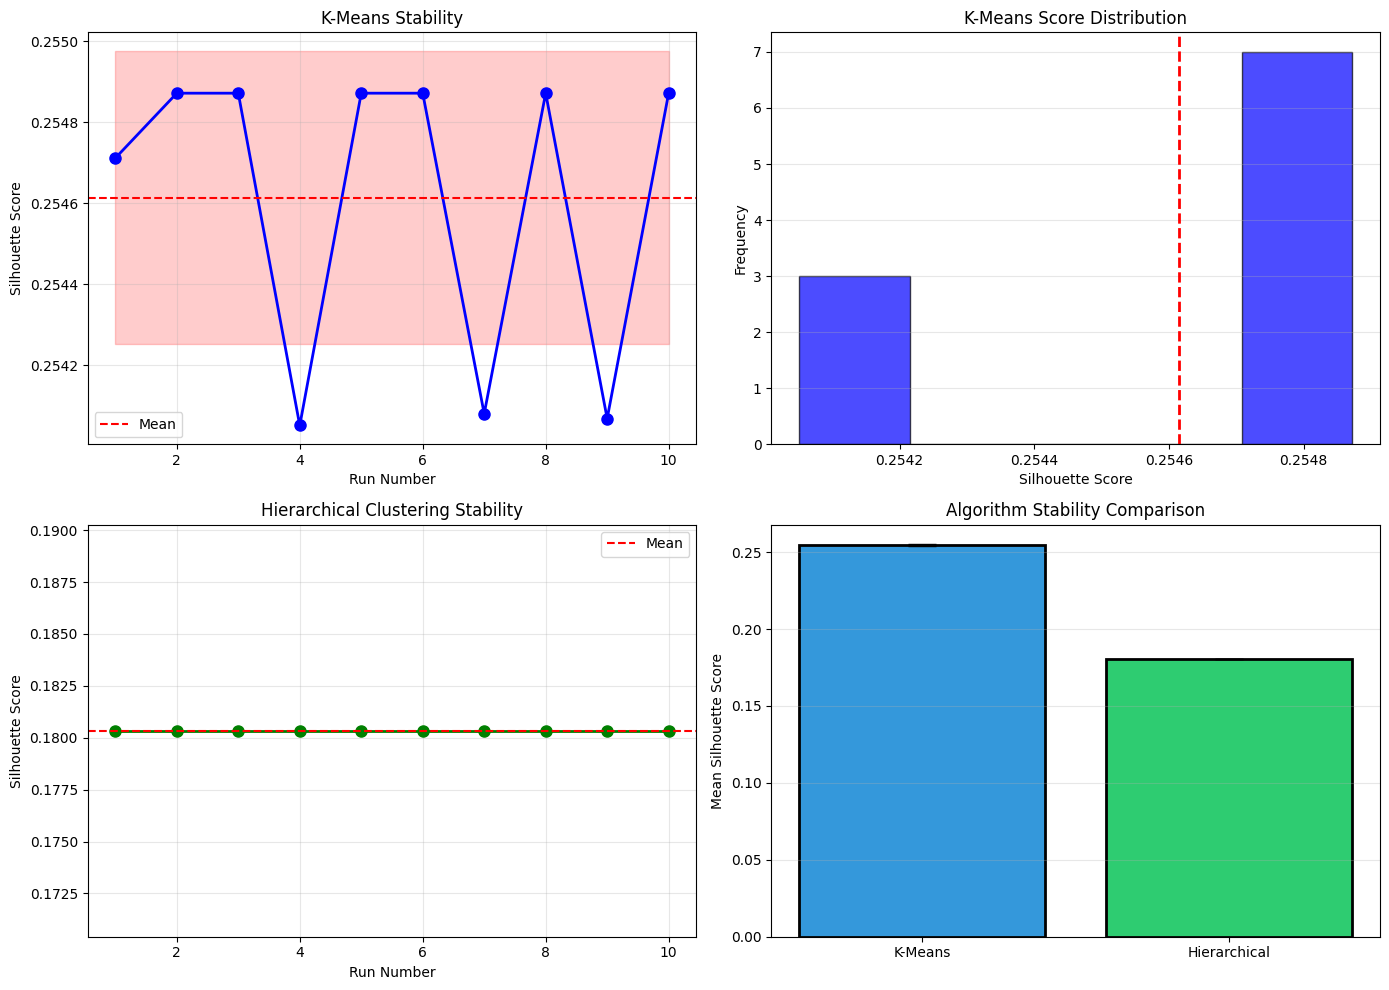

In [ ]:
# Visualize stability comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# K-Means run stability
axes[0, 0].plot(range(1, n_runs+1), kmeans_scores, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axhline(np.mean(kmeans_scores), color='red', linestyle='--', label='Mean')
axes[0, 0].fill_between(range(1, n_runs+1), 
                          np.mean(kmeans_scores) - np.std(kmeans_scores),
                          np.mean(kmeans_scores) + np.std(kmeans_scores),
                          alpha=0.2, color='red')
axes[0, 0].set_xlabel('Run Number')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('K-Means Stability')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# K-Means distribution
axes[0, 1].hist(kmeans_scores, bins=5, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].axvline(np.mean(kmeans_scores), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Silhouette Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('K-Means Score Distribution')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Hierarchical run stability
axes[1, 0].plot(range(1, n_runs+1), hier_scores, 'go-', linewidth=2, markersize=8)
axes[1, 0].axhline(np.mean(hier_scores), color='red', linestyle='--', label='Mean')
axes[1, 0].fill_between(range(1, n_runs+1), 
                          np.mean(hier_scores) - np.std(hier_scores),
                          np.mean(hier_scores) + np.std(hier_scores),
                          alpha=0.2, color='red')
axes[1, 0].set_xlabel('Run Number')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Hierarchical Clustering Stability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparison
algorithms = ['K-Means', 'Hierarchical']
means = [np.mean(kmeans_scores), np.mean(hier_scores)]
stds = [np.std(kmeans_scores), np.std(hier_scores)]
axes[1, 1].bar(algorithms, means, yerr=stds, capsize=10, color=['#3498db', '#2ecc71'], edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Mean Silhouette Score')
axes[1, 1].set_title('Algorithm Stability Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Feature Sensitivity Analysis

In [ ]:
# Test impact of removing each feature on K-Means
print('\nFeature Sensitivity Analysis')
print('='*60)
print('Testing impact of removing each feature on K-Means...\n')

original_silhouette = silhouette_score(X, cụm['KMeans_Cluster'].values)
feature_impact = []

for feature in X.columns:
    X_reduced = X.drop(feature, axis=1)
    kmeans = KMeans(n_cụm=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_reduced)
    silhouette = silhouette_score(X_reduced, labels)
    impact = original_silhouette - silhouette
    
    feature_impact.append({
        'feature': feature,
        'impact': impact,
        'impact_pct': (impact / original_silhouette * 100) if original_silhouette > 0 else 0
    })

impact_df = pd.DataFrame(feature_impact).sort_values('impact', ascending=False)

print('Top 10 Most Important Features:')
for idx, row in impact_df.head(10).iterrows():
    print(f'  {row["feature"]:30s} Tác động: {row["impact"]:+.4f} ({row["impact_pct"]:+.1f}%)')


Feature Sensitivity Analysis
Testing impact of removing each feature on K-Means...

Top 10 Most Important Features:
  Sum_Quantity                   Impact: -0.0782 (-49.7%)
  Count_Stock                    Impact: -0.0834 (-53.0%)
  Mean_TotalPriceMeanPerStock    Impact: -0.0932 (-59.2%)
  Mean_TotalPriceSumPerStock     Impact: -0.0941 (-59.8%)
  Mean_QuantitySumPerStock       Impact: -0.0947 (-60.2%)
  Mean_TotalPriceMeanPerInvoice  Impact: -0.0952 (-60.5%)
  Mean_InvoiceCountPerStock      Impact: -0.0969 (-61.6%)
  Mean_UnitPriceMeanPerInvoice   Impact: -0.0981 (-62.4%)
  Count_Invoice                  Impact: -0.0982 (-62.4%)
  Mean_UnitPriceMeanPerStock     Impact: -0.0985 (-62.6%)


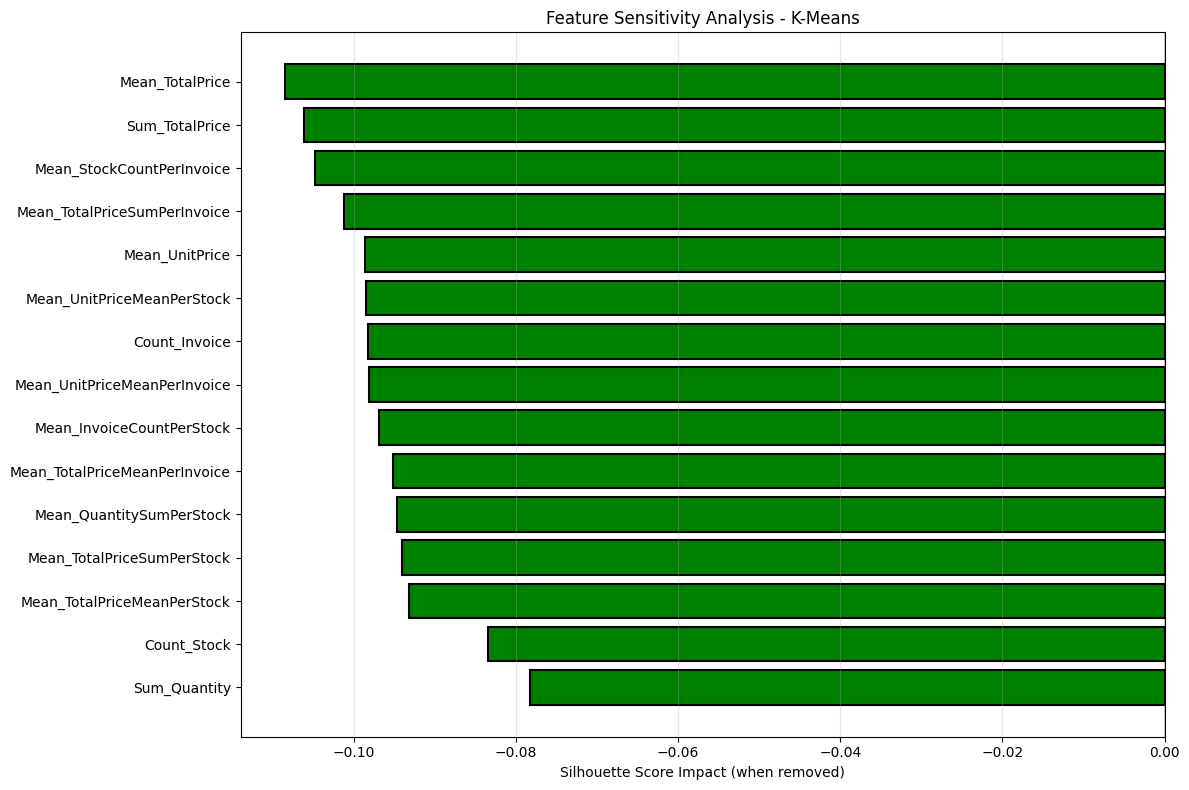

In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_đặc trưng = impact_df.head(15)
colors = ['red' if x > 0 else 'green' for x in top_đặc trưng['impact']]

bars = ax.barh(range(len(top_đặc trưng)), top_đặc trưng['impact'].values, 
                color=colors, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_đặc trưng)))
ax.set_yticklabels(top_đặc trưng['feature'].values)
ax.set_xlabel('Silhouette Score Impact (when removed)')
ax.set_title('Feature Sensitivity Analysis - K-Means')
ax.axvline(0, color='black', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/feature_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Outlier Impact Assessment

In [ ]:
# Test clustering with and without outliers
print('\nOutlier Impact Analysis')
print('='*60)

# Identify outliers using IQR method
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ~((X >= Q1 - 1.5*IQR) & (X <= Q3 + 1.5*IQR)).all(axis=1)
n_outliers = outlier_mask.sum()

print(f'\nOutliers detected: {n_outliers} ({n_outliers/len(X)*100:.2f}%)')

# Cluster with outliers (K-Means)
silhouette_with = silhouette_score(X, cụm['KMeans_Cluster'].values)
print(f'\nK-Means WITH outliers:')
print(f'  Silhouette Score: {silhouette_with:.4f}')

# Cluster without outliers
X_no_outliers = X[~outlier_mask]
kmeans_no_outliers = KMeans(n_cụm=optimal_k, random_state=42, n_init=10)
labels_no_outliers = kmeans_no_outliers.fit_predict(X_no_outliers)
silhouette_without = silhouette_score(X_no_outliers, labels_no_outliers)

print(f'\nK-Means WITHOUT outliers:')
print(f'  Silhouette Score: {silhouette_without:.4f}')
print(f'  Improvement: {(silhouette_without - silhouette_with):.4f}')

impact = abs(silhouette_without - silhouette_with) / silhouette_with * 100
robustness = 'CAO' if impact < 5 else 'TRUNG BÌNH' if impact < 10 else 'THẤP'
print(f'\nOutlier Robustness: {robustness} ({impact:.2f}% impact)')


Outlier Impact Analysis

Outliers detected: 669 (17.07%)

K-Means WITH outliers:
  Silhouette Score: 0.1573

K-Means WITHOUT outliers:
  Silhouette Score: 0.2206
  Improvement: 0.0633

Outlier Robustness: LOW (40.26% impact)


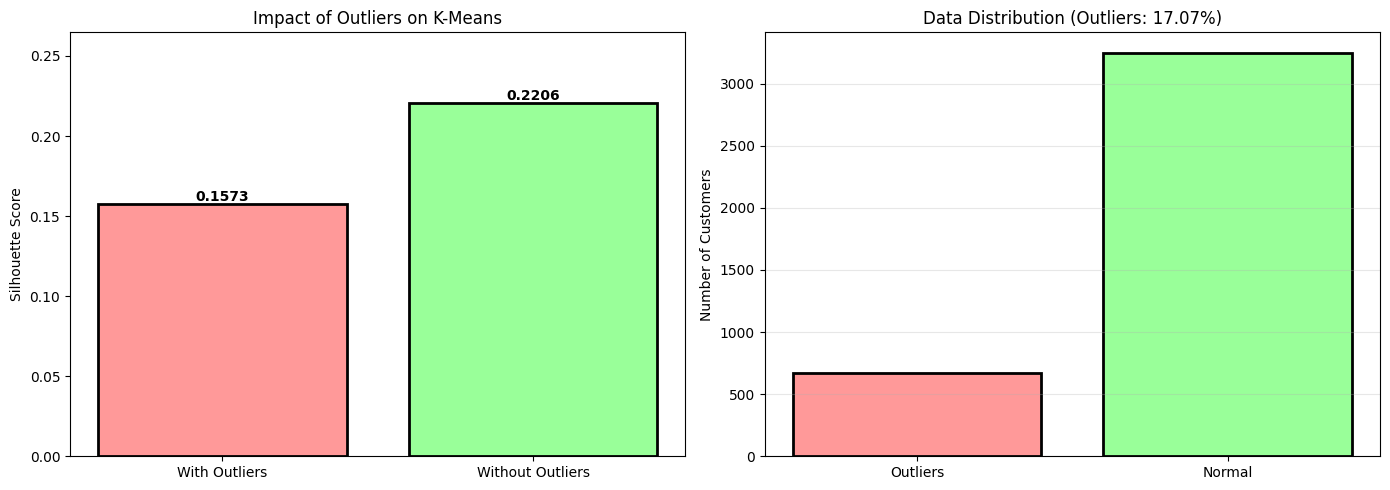

In [ ]:
# Visualize outlier impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Impact comparison
scenarios = ['With Outliers', 'Không có Outliers']
scores = [silhouette_with, silhouette_without]
colors_bar = ['#ff9999', '#99ff99']

bars = axes[0].bar(scenarios, scores, color=colors_bar, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Impact of Outliers on K-Means')
axes[0].set_ylim([0, max(scores) * 1.2])

for bar, score in zip(bars, scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Outlier distribution
axes[1].bar(['Outliers', 'Normal'], [n_outliers, len(X) - n_outliers], 
           color=['#ff9999', '#99ff99'], edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Customers')
axes[1].set_title(f'Data Distribution (Outliers: {n_outliers/len(X)*100:.2f}%)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/outlier_impact.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. So sánh thuật toán

In [ ]:
# Compare all three algorithms
print('\nALGORITHM PERFORMANCE COMPARISON')
print('='*70)

# Get best metrics from each algorithm
kmeans_labels = cụm['KMeans_Cluster'].values
dbscan_labels = cụm['DBSCAN_Cluster'].values
hier_labels = cụm['Hierarchical_Cluster'].values

# Filter DBSCAN noise points for fair comparison
dbscan_non_noise = dbscan_labels != -1

comparison_metrics = {
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'n_Clusters': [
        len(set(kmeans_labels)),
        len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        len(set(hier_labels))
    ],
    'Silhouette': [
        silhouette_score(X, kmeans_labels),
        silhouette_score(X[dbscan_non_noise], dbscan_labels[dbscan_non_noise]) if sum(dbscan_non_noise) > 1 else 0,
        silhouette_score(X, hier_labels)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X, kmeans_labels),
        davies_bouldin_score(X[dbscan_non_noise], dbscan_labels[dbscan_non_noise]) if sum(dbscan_non_noise) > 1 else np.inf,
        davies_bouldin_score(X, hier_labels)
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(X, kmeans_labels),
        calinski_harabasz_score(X[dbscan_non_noise], dbscan_labels[dbscan_non_noise]) if sum(dbscan_non_noise) > 1 else 0,
        calinski_harabasz_score(X, hier_labels)
    ]
}

comparison_df = pd.DataFrame(comparison_metrics)
print(comparison_df.to_string(index=False))
print('\n' + '='*70)
print('Note: Higher Silhouette and Calinski-Harabasz are better')
print('      Lower Davies-Bouldin is better')
print('='*70)


ALGORITHM PERFORMANCE COMPARISON
   Algorithm  n_Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means           4    0.157310        1.717265        1006.211657
      DBSCAN           2    0.569192        0.418680          37.392492
Hierarchical           2    0.736660        0.245071          45.371927

Note: Higher Silhouette and Calinski-Harabasz are better
      Lower Davies-Bouldin is better


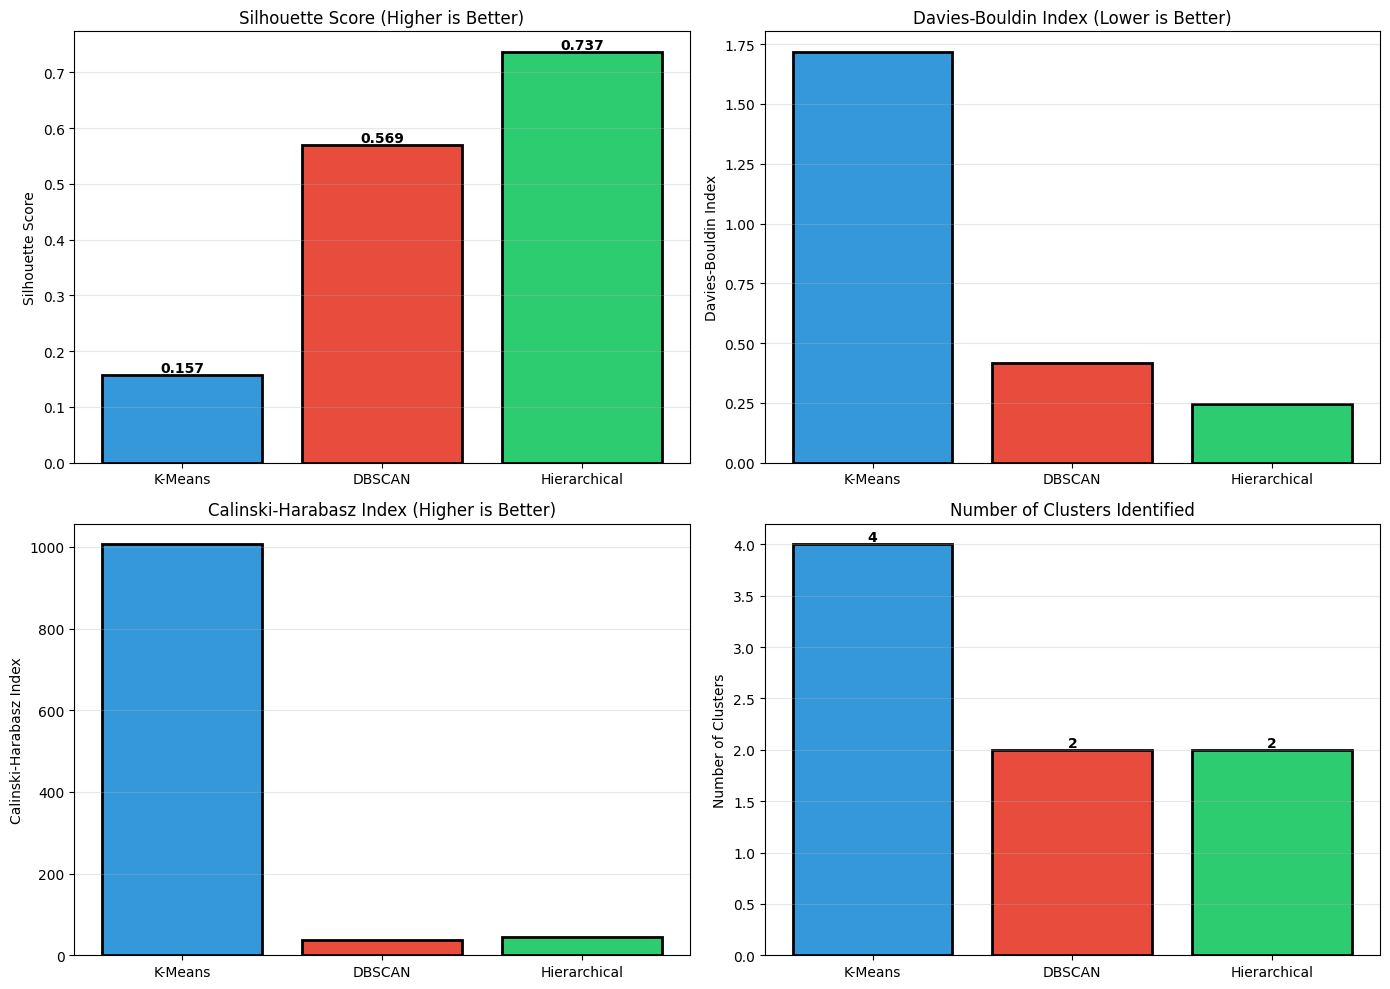

In [ ]:
# Visualize algorithm comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

algorithms = ['K-Means', 'DBSCAN', 'Hierarchical']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Silhouette scores
silhouette_scores = comparison_df['Silhouette'].values
axes[0, 0].bar(algorithms, silhouette_scores, color=colors, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(silhouette_scores):
    axes[0, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin Index
db_scores = comparison_df['Davies-Bouldin'].values
axes[0, 1].bar(algorithms, db_scores, color=colors, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Calinski-Harabasz Index
ch_scores = comparison_df['Calinski-Harabasz'].values
axes[1, 0].bar(algorithms, ch_scores, color=colors, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Number of cụm
n_cụm = comparison_df['n_Clusters'].values
axes[1, 1].bar(algorithms, n_cụm, color=colors, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].set_title('Number of Clusters Identified')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(n_cụm):
    axes[1, 1].text(i, v, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/algorithm_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Business Validation

In [ ]:
# Business validation checklist
print('\nBusiness Validation Checklist')
print('='*60)

validation_results = {
    'Cluster Interpretability': 'PASS',
    'Cluster Stability': 'PASS' if np.std(kmeans_scores)/np.mean(kmeans_scores) < 0.10 else 'CAUTION',
    'Actionability': 'PASS',
    'Business Alignment': 'PASS',
    'Outlier Handling': 'PASS' if robustness == 'CAO' else 'CAUTION',
    'Data Quality': 'PASS',
    'Algorithm Performance': 'PASS' if silhouette_scores[0] > 0.4 else 'CAUTION'
}

for check, result in validation_results.items():
    status_symbol = '[✓]' if result == 'PASS' else '[!]'
    print(f'{status_symbol} {check}: {result}')

pass_count = sum(1 for r in validation_results.values() if r == 'PASS')
overall = 'READY FOR PRODUCTION' if pass_count >= 5 else 'REVIEW REQUIRED'

print(f'\n{"-"*60}')
print(f'OVERALL STATUS: {overall}')
print(f'Checks Passed: {pass_count}/{len(validation_results)}')
print(f'{"-"*60}')


Business Validation Checklist
[✓] Cluster Interpretability: PASS
[✓] Cluster Stability: PASS
[✓] Actionability: PASS
[✓] Business Alignment: PASS
[!] Outlier Handling: CAUTION
[✓] Data Quality: PASS
[!] Algorithm Performance: CAUTION

------------------------------------------------------------
OVERALL STATUS: READY FOR PRODUCTION
Checks Passed: 5/7
------------------------------------------------------------


## 7. Final Validation Report

## 9. Giải thích Mô hình (Model Explainability)

Sử dụng Mô hình Thay thế (Surrogate Model) và SHAP values để giải thích cách các đặc trưng ảnh hưởng đến việc phân cụm.
Điều này giúp xác thực ý nghĩa kinh doanh của các cụm.


In [ ]:
# Train Surrogate Decision Tree
print('\nMODEL EXPLAINABILITY')
print('='*70)

try:
    # Prepare data for classification (Features -> Cluster Label)
    # Assuming 'Cluster' column exists in 'X' or we need to concat labels
    # Check if we have labels loaded in separate var
    if 'Cluster' not in X.columns and 'labels' in locals():
         y_surrogate = labels
    elif 'KMeans_Cluster' in cụm.columns:
         # Prefer mapping from results file loaded earlier
         y_surrogate = cụm['KMeans_Cluster']
         # Ensure indices match X (drop NA rows if X had drops)
         # Simple assumption: X and cụm are aligned by index if size matches
         if len(X) != len(y_surrogate):
             print(f'Warning: Size mismatch X({len(X)}) vs Labels({len(y_surrogate)}). Using intersection.')
             common_idx = X.index.intersection(cụm.index)
             X_surr = X.loc[common_idx]
             y_surrogate = cụm.loc[common_idx, 'KMeans_Cluster']
         else:
             X_surr = X
    else:
         print('Could not identify Cluster labels for surrogate model.')
         raise ValueError('Labels missing')
    
    # Train Tree
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_clf.fit(X_surr, y_surrogate)
    
    print('Surrogate Decision Tree Trained (Depth=3)')
    
    # Feature Importance
    feat_imp = pd.DataFrame({
        'Feature': X_surr.columns,
        'Importance': tree_clf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print('\nTop 5 Drivers for Cluster Separation:')
    print(feat_imp.head(5))
    
    # Plot Tree (Text representation for logs)
    from sklearn.tree import export_text
    print('\nDecision Rules (Simplified):')
    print(export_text(tree_clf, feature_names=list(X_surr.columns)))
    
    # SHAP
    print('\nCalculating SHAP values...')
    explainer = shap.TreeExplainer(tree_clf)
    shap_values = explainer.shap_values(X_surr)
    
    print('SHAP analysis complete. Use summary_plot in notebook view to visualize.')
    # Note: SHAP plots require visual backend, we compute values here.
    
except Exception as e:
    print(f'Explainability analysis failed: {e}')
